A demonstration of `pcshrink` on a simple real-data example constructed by Nick Patterson:
https://reich.hms.harvard.edu/sites/reich.hms.harvard.edu/files/inline-files/shrinkdemo.tar.gz

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import the package!
import pcshrink

plt.style.use("seaborn-white")

## Functions

In [2]:
def get_genotype_matrix(geno_path, n, p):
    """Gets the genotype matrix stored as a
    numpy array
    """
    # read the geno file
    with open(geno_path, "r") as f:
        matstr = f.read().replace("\n", "")

    # convert to long array
    ys = np.fromstring(matstr, dtype=np.int8) - 48
    
    # reshape to p x n matrix
    Y = ys.reshape(p, n).astype(np.float32)
    
    # replace 9s with nans
    Y[Y == 9] = np.nan
    
    return(Y)

## Experiment

Read the data ...

In [3]:
n = 60
p = 120631
k = 2

#### genoty mat ####
Y = get_genotype_matrix("../data/yfhx.geno", n=n, p=p)
print(Y.shape)

#### ind df ####
ind_df = pd.read_table("../data/yfhx.ind", sep="\s+", header=None)
ind_df.columns = ["ind", "sex", "clst"]
print(ind_df.head())

#### snp df ####
snp_df = pd.read_table("../data/yfhx.snp", sep="\s+", header=None)
snp_df.columns = ["snp", "chrom", "cm", "pos", "a1", "a2"]

# extract idx of all snps on the autosomes
auto_idx = snp_df[snp_df["chrom"] <= 22].index
print(auto_idx.shape)
print(snp_df.head())

/project/jnovembre/jhmarcus/src/miniconda3/envs/pcshrink_e/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


(120631, 60)
         ind sex    clst
0  HGDP00511   M  French
1  HGDP00512   M  French
2  HGDP00513   F  French
3  HGDP00514   F  French
4  HGDP00515   M  French
(120083,)
             snp  chrom        cm      pos a1 a2
0  Affx-15871758      1  0.025727   949654  A  G
1   Affx-3979904      1  0.026674  1048955  A  G
2   Affx-4572154      1  0.029335  1156131  T  C
3   Affx-4575207      1  0.029356  1157547  T  C
4   Affx-4584321      1  0.029391  1161780  C  T


Split inds into test / train ...

In [4]:
# individual idx in the test set
test_idx = np.array([x[-1] == "X" for x in ind_df["clst"].values])

# genotype matricies of train and test individuals
Y_train = Y[auto_idx, :][:, ~test_idx]
Y_test = Y[auto_idx, :][:, test_idx]

ind_train_df = ind_df.iloc[~test_idx]
ind_test_df = ind_df.iloc[test_idx]

Normalize the data and run intial PCA

In [5]:
# center and scale the data
norm = pcshrink.Normalizer(Y_train, eps=0.05, scale_type="patterson")

# construct the ShrinakgeCorrector
pc = pcshrink.ShrinkageCorrector(norm.Y, k=k)
L = pc.L

Jackknife estimate of the shrinkage correction factor ...

In [6]:
%%time
# use truncated svd for each held-out ind
pc.jackknife(downdate=False, o=5)
print(pc.tau)

holding out sample 0
holding out sample 5
holding out sample 10
holding out sample 15
holding out sample 20
holding out sample 25
[1.25870383 1.39923424]
CPU times: user 9.06 s, sys: 25.5 s, total: 34.5 s
Wall time: 1.23 s


Fast rank-1 downdate estimator ...

In [7]:
%%time
# use rank-1 downdate for each held-out ind
pc.jackknife(downdate=True, o=5)
print(pc.tau)

holding out sample 0
holding out sample 5
holding out sample 10
holding out sample 15
holding out sample 20
holding out sample 25
[1.25870376 1.39923468]
CPU times: user 4.61 s, sys: 11.4 s, total: 16 s
Wall time: 573 ms


Notice the correction factor $\tau$ for the 2 PCs are very similar. Lets now wormalize test data with mean and scale of training dataset and project on to training pcs ...

In [8]:
# normalize test genotypes 
Z_test = (Y_test[norm.snp_idx, :] - norm.mu) / norm.s

# corrected projected pc-scores! 
L_test = pc.lstsq_project(Z_test)

projecting sample 0
projecting sample 10
projecting sample 20


Create a DataFrame of results and plot! ...

In [9]:
# train data
train_df = pd.DataFrame(L)
train_df.columns = ["PC1", "PC2"]
train_df["clst"] = ind_train_df["clst"].values
train_df["type"] = "Train"

# "uncorrected" test data
test_raw_df = pd.DataFrame((1 / pc.tau) * L_test)
test_raw_df.columns = ["PC1", "PC2"]
test_raw_df["clst"] = ind_test_df["clst"].apply(lambda x: x.strip("X")).values
test_raw_df["type"] = "Test-Uncorrected"

# "corrected" test data
test_df = pd.DataFrame(L_test)
test_df.columns = ["PC1", "PC2"]
test_df["clst"] = ind_test_df["clst"].apply(lambda x: x.strip("X")).values
test_df["type"] = "Test-Corrected"

pc_df = pd.concat([train_df, test_df, test_raw_df])
pc_df.head()

,PC1,PC2,clst,type
0,-94.166885,160.252182,French,Train
1,-96.387779,155.526688,French,Train
2,-94.680557,154.622269,French,Train
3,-97.370537,158.911804,French,Train
4,-95.062538,154.481842,French,Train


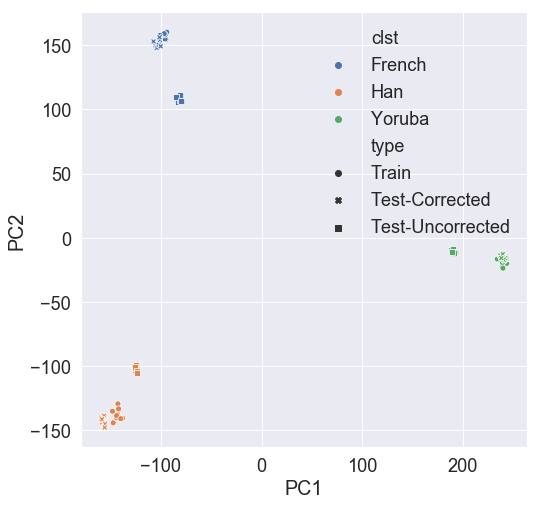

In [10]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.65) 
sns.scatterplot("PC1", "PC2", data=pc_df, hue="clst", style="type");

See `../data/x1s.yfhx.pdf` to compare to Patterson's result. Our correction is possibly not as good for Han but overall is pretty satisfying!

## Compare to EigenStrat

`TODO: Direct Comparison`